In [2]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io 

%load_ext autoreload 
%autoreload 2

is_homogenous = lambda df : df.category.nunique() == 1

In [9]:
# Want to compare the regions where the divergence scores are highest. Would expect to see higher divergence scores around
# the N-terminus when comparing Pyl+ vs. Pyl-. Probably should control for evolutionary distance, i.e. compare clades which are similarly
# distant. Probably the easiest way to do this is by clustering the release factors and then building a tree of the representatives. 

arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)
# build_stop_codon_genome_metadata_dataset(arf1_df.genome_id.unique())
stop_codon_genome_metadata_df = pd.read_csv('../data/arf1_stop_codon_metadata.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count


# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')
print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'none').sum())
arf1_df = arf1_df[arf1_df.category != 'none'].copy()

Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73


In [ ]:
# with open('../data/ar53.tree', 'r') as f:
#     tree = f.read()
# tree = tree.replace('RS_', '').replace('GB_', '') # Remove the prefixes to allow mapping. 
# tree = get_tree_subset(tree, ids=arf1_df.genome_id.values)
# tree = Phylo.read(io.StringIO(tree), format='newick')
# Phylo.write(tree, 'ar53_pruned.tree', format='newick')

In [4]:
# I think the clustering approach from sandbox-1 is flawed, because it is pretty clear that aRF1 similarity might not track phylogeny. 
# By clustering by aRF1 similarity, I am kind of defeating the purpose of controlling for phylogeny in the comparisons. I think 
# instead of clustering, it might make more sense to count the number of significant mutations between similarly-related organisms
# in different categories. 

In [18]:
tree = Phylo.read('../data/ar53_pruned.tree', format='newick')

def get_distances(arf1_df, tree, max_distance=2.5):

    arf1_df = arf1_df.copy()
    arf1_df['protein_id'] = arf1_df.index 
    arf1_df = arf1_df.set_index('genome_id') # Need to use the genome ID as an index to work with the tree. 

    # Precompute the distances to the roots. 
    leaves = [tree.find_any(genome_id) for genome_id in arf1_df.index]
    distances_to_root = {leaf:tree.distance(tree.root, leaf) for leaf in leaves} # Can use the clade objects themselves as keys. 

    distance_df = list()

    for leaf_1, leaf_2 in tqdm(list(combinations(leaves, 2)), desc='get_distances'):
        genome_id_1, genome_id_2 = leaf_1.name, leaf_2.name 
        row = {'genome_id_1':leaf_1.name, 'genome_id_2':leaf_2.name}

        lca = tree.common_ancestor(leaf_1, leaf_2) # Using the LCA to get distance is *much* faster (thanks ChatGPT)... should look into why. 
        lca_distance_to_root = distances_to_root.get(lca, tree.distance(tree.root, lca)) # Only compute the distance if it's not already in the dictionary. 
        distances_to_root[lca] = lca_distance_to_root # Store in the lookup table. 
        distance = distances_to_root[leaf_1] + distances_to_root[leaf_2] - (2 * lca_distance_to_root)

        if distance < max_distance:
            row['distance'] = distance 
            row['category_1'], row['category_2'] = arf1_df.loc[genome_id_1].category, arf1_df.loc[genome_id_2].category
            row['protein_id_1'], row['protein_id_2'] = arf1_df.loc[genome_id_1].protein_id, arf1_df.loc[genome_id_2].protein_id
            row['category'] = ' vs. '.join(sorted([row['category_1'], row['category_2']]))
            distance_df.append(row) # Only add if the distance is not too far. 

    distance_df = pd.DataFrame(distance_df)
    return distance_df

tree = Phylo.read('../data/ar53_pruned.tree', format='newick')
distance_df = get_distances(arf1_df, tree)
        

get_distances: 100%|██████████| 2917320/2917320 [48:08<00:00, 1010.11it/s] 


In [20]:
distance_df.to_csv('../data/arf1_pair_distances.csv')

In [269]:
min_cluster_size = 4
print(f'Num. clusters with size > {min_cluster_size}:', (cluster_df.groupby('cluster_id').size() > min_cluster_size).sum())
cluster_df = cluster_df[cluster_df.cluster_size > min_cluster_size].copy()

print('Num. homogenous clusters:', cluster_df.groupby('cluster_id').apply(is_homogenous, include_groups=False).sum())
cluster_df['homogenous'] = cluster_df.cluster_id.map(cluster_df.groupby('cluster_id').apply(is_homogenous, include_groups=False))
cluster_df = cluster_df[cluster_df.homogenous].copy()
cluster_rep_df = cluster_df[cluster_df.representative].copy()

# Use the genome ID as the index here to allow mapping to the tree. 
FASTAFile().from_df(cluster_df[cluster_df.representative].set_index('genome_id')).write('../data/arf1_cleaned_rep_seq.fasta')
run_muscle('../data/arf1_cleaned_rep_seq.fasta', build_tree=False)

Num. clusters with size > 4: 104
Num. homogenous clusters: 98
run_muscle: Generating file ../data/arf1_cleaned_rep_seq.afa


In [276]:

rep_genome_ids = cluster_rep_df.genome_id.unique()
tree = Phylo.read('../data/ar53_pruned.tree', format='newick')
tree = get_tree_subset(tree, ids=rep_genome_ids)
Phylo.write(tree, '../data/arf1_cleaned_cluster_rep_seq.tree', format='newick')

def get_comparison_pairs(cluster_df, tree, rep_genome_ids:list=None, min_dist=0, max_dist=5):

    cluster_df['protein_id'] = cluster_df.index
    cluster_df = cluster_df.copy().set_index('genome_id') # Use the genome ID as the index to allow cross-referencing to the tree. 

    pair_df = list()
    for id_1, id_2 in combinations(rep_genome_ids, 2):
        dist = tree.distance(tree.find_any(id_1), tree.find_any(id_2))
        if (dist > min_dist) and (dist < max_dist):
            row = dict()
            row['id_1'], row['id_2'] = id_1, id_2
            row['protein_id_1'], row['protein_id_2'] = cluster_df.loc[id_1].protein_id, cluster_df.loc[id_2].protein_id
            row['category_1'], row['category_2'] = cluster_df.loc[id_1].category, cluster_df.loc[id_2].category
            row['cluster_id_1'], row['cluster_id_2'] = cluster_df.loc[id_1].cluster_id, cluster_df.loc[id_2].cluster_id
            row['distance'] = dist
            pair_df.append(row)

    pair_df = pd.DataFrame(pair_df)
    pair_df['pair_category'] = [' vs. '.join(sorted([row.category_1, row.category_2])) for row in pair_df.itertuples()]
    return pair_df

pair_df = get_comparison_pairs(cluster_rep_df, tree, rep_genome_ids=rep_genome_ids)

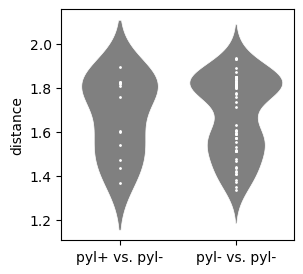

In [277]:
min_dist, max_dist = 1.3, 1.9

# Select pyl+ recoded vs. pyl- pairs in the distance range. 
ids = pair_df[(pair_df.pair_category ==  'pyl+ recoded vs. pyl-') & (pair_df.distance < max_dist) & (pair_df.distance > min_dist)].index.tolist()
distances = pair_df.loc[ids].distance

def get_pyl_minus_vs_pyl_minus_ids(pair_df, distances, delta:float=0.05, n_per_distance:int=5):
    np.random.seed(42)
    sample_ids = list()
    for distance in distances:
        ids_ = pair_df[(pair_df.distance < (distance + delta)) & (pair_df.distance > (distance - delta)) & (pair_df.pair_category == 'pyl- vs. pyl-')].index
        ids_ = np.random.choice(ids_, n_per_distance, replace=False)
        sample_ids += ids_.tolist()
    return sample_ids

sample_ids = ids + get_pyl_minus_vs_pyl_minus_ids(pair_df, distances)

# Visualize the samples to ensure the phylogenetic distance distributions are approzimately equal. 
fig, ax = plt.subplots(figsize=(3, 3))
figure_df = pair_df.loc[sample_ids].copy()
figure_df = figure_df[figure_df.pair_category.isin(['pyl- vs. pyl-', 'pyl+ recoded vs. pyl-'])].copy()
figure_df['pair_category'] = figure_df.pair_category.replace({'pyl+ recoded vs. pyl-':'pyl+ vs. pyl-'})

sns.violinplot(figure_df, x='pair_category', y='distance', ax=ax, color='gray', linewidth=0.5, edgecolor='white', inner='point') #, jitter=True)
ax.set_xlabel('')
plt.show()

In [272]:
figure_df = list()

for row in pair_df.loc[sample_ids].itertuples():
    ids = cluster_df[cluster_df.cluster_id.isin([row.cluster_id_1, row.cluster_id_2])].index
    index, alignment = load_msa(path='../data/arf1_cleaned.afa', conservation_threshold=0.9, ids=ids) # Should load the sequences from Methanosarcinales only. 

    alignment_df = pd.DataFrame(alignment, index=index)
    alignment_df['cluster_id'] = cluster_df.cluster_id
    scores = get_scores(alignment_df, group_by='cluster_id', normalize=True)
    positions = np.arange(len(scores))[scores > 0.99]
    df = pd.DataFrame(pd.Series(positions, name='highest_score_positions'))
    df['pair_category'] = row.pair_category
    df['id_1'], df['id_2'] = row.id_1, row.id_2
    df['alignment_length'] = alignment.shape[-1]
    figure_df.append(df)
figure_df = pd.concat(figure_df)

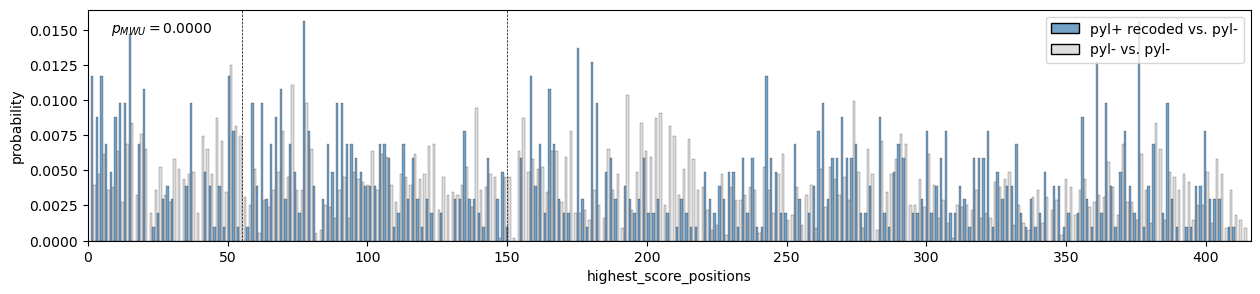

In [273]:

fig, ax = plt.subplots(figsize=(15, 3))
palette = {'pyl- vs. pyl-':'lightgray', 'pyl+ recoded vs. pyl-':'steelblue'}
# palette = {'pyl- vs. pyl-':'gray', 'pyl+ recoded vs. pyl-':'steelblue', 'pyl+ vs. pyl-':'lightgray'}

# sns.kdeplot(figure_df[figure_df.pair_category.isin(palette.keys())], ax=ax, x='highest_score_positions', hue='pair_category', common_norm=False, bw_adjust=0.1, palette=palette)
sns.histplot(figure_df[figure_df.pair_category.isin(palette.keys())], ax=ax, x='highest_score_positions', hue='pair_category', common_norm=False, bins=250, stat='probability', palette=palette, multiple='dodge')
sns.move_legend(ax, loc='upper right')
ax.legend_.set_title('')
ax.set_xlim(xmin=0, xmax=416)
ax.set_ylabel('probability')

min_position, max_position = 55, 150
values_1 = figure_df[figure_df.pair_category == 'pyl+ recoded vs. pyl-'].highest_score_positions.values
values_2 = figure_df[figure_df.pair_category == 'pyl- vs. pyl-'].highest_score_positions.values

values_1 = values_1[(values_1 > min_position) & (values_1 < max_position)]
values_2 = values_2[(values_2 > min_position) & (values_2 < max_position)]
stat, p = mannwhitneyu(values_1, values_2, alternative='two-sided')
ax.text(0.02, 0.9, '$p_{MWU}=$' + f'{p:.4f}', transform=ax.transAxes)

ax.axvline(min_position, color='black', ls='--', lw=0.5)
ax.axvline(max_position, color='black', ls='--', lw=0.5)

plt.show()
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3795251/



In [274]:
connections = figure_df.drop_duplicates(['id_1', 'id_2'])
connections = list(zip(connections[connections.pair_category == 'pyl+ recoded vs. pyl-'].id_1, connections[connections.pair_category == 'pyl+ recoded vs. pyl-'].id_2))

make_itol_connection(connections, path='../data/itol/arf1_cleaned_rep_seq_connection.txt')

palette = {'pyl+ recoded':darkgreen, 'pyl-':gray, 'pyl+':black}
make_itol_annotation(cluster_rep_df.set_index('genome_id'), field='category', path='../data/itol/arf1_cleaned_rep_seq_category_annotation.txt', palette=palette)
